(-0.5, 426.5, 565.5, -0.5)

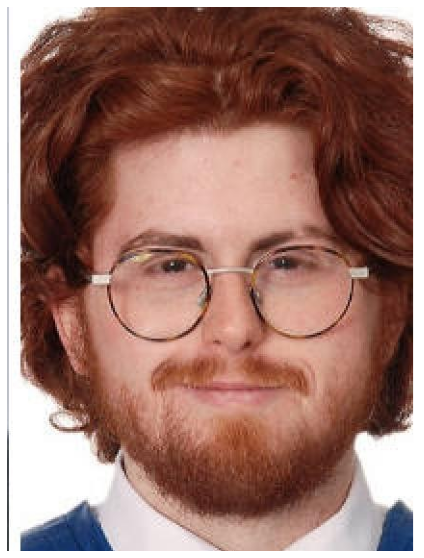

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
jpgfile = Image.open("rub.jpeg")
fig, axs = plt.subplots(1,figsize=(10,10))
plt.imshow(jpgfile)
plt.axis('off')

In [2]:
import networkx as nx
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import njit

# Functions

## Adjacency Matrix

In [1154]:
def full(N, muE, muI=None, nI=None):
  '''
  Returns a fully connected matrix with a fraction
  nI of inhibitory synapses. The weights are sampled from
  Normal distributions being muE/I their means
  '''
  inh = []
  if nI is not None:
    inh = random.sample(range(N), round(nI*N))
  M = np.empty((N,N))
  for i in range(N):
    # Inhibitory
    if i in inh:  M[i,:] = np.random.normal(-muI,1/N,N) 
    #Excitatory
    else:  M[i,:] =  np.random.normal(muE,1/N,N)
  # Exclude self-interactions  
  np.fill_diagonal(M, np.zeros(N)) 
  return M, inh

def get_W(M, wE,wI):
    '''
    Obtain matrix with entries being wE if excitatory and -wI if inhibitory
    '''
    W = np.where(M > 0, wE, M)
    W = np.where(W < 0, -wI, W)
    return W

def sparse(M, density=.2):
    '''
    Add sparsity to the matrix M by leaving roughly a number of 
    non-zero entries of the order of N
    '''
    N = len(M)
    Msparse = np.zeros((N,N))
    for idx, x in np.ndenumerate(M):
        if random.random() > density: 
            Msparse[idx] = 0
        else:
            Msparse[idx] = x
    return Msparse

def sparse2(M,p=None,k=None):
    '''K_out = p(N-1)'''
    N = len(M)
    if p is not None: k = round(p*(N-1))
    Msparse = np.zeros((N,N))   
    
    for i in range(N):
        nonzero = random.sample(range(N), k)
        Msparse[i,nonzero] = M[i,nonzero]  
    
    return Msparse

def modulate_II(M, val=0):
    for i in inh:
        for j in inh:
            M[i,j] = val
    return M

## Eigenvalue inspection 

In [1155]:
def plot_eigenvals(W,plot=True):
    e, v = np.linalg.eig(W)
    e_r0 = np.real(e)
    e_i0 = np.imag(e)
    
    if plot:
        circle1=plt.Circle((0, 0), 1, color='pink')
        plt.gca().add_patch(circle1)
        plt.plot(e_r0,e_i0, 'o ',lw=1,marker='o', ms=3, markeredgewidth=2,  mec='black',mfc='red', label='N=$10$')
        plt.axis('equal')
        #print('Max modulus: ',np.sort(np.sqrt(e_r0**2 + e_i0**2))[-5:])
        plt.plot(e_r0,e_i0, 'o ',lw=1,marker='o', ms=5, markeredgewidth=2,  mec='black',mfc='red', label='N=$10$');
    
    # Sort unique values in descending order
    sort_by_norm = np.sort(list(set(np.round(np.sqrt(e_r0**2 + e_i0**2),5))))[::-1] 
    sort_by_real = np.sort(list(set(np.round((e_r0),5))))[::-1] 
    return sort_by_norm, sort_by_real

def mean_syn(W):
    '''Obtain mean synaptic weights'''
    return [np.mean([np.mean(W[:,j][W[:,j]!=0]) for j in set(range(0,N)) - set(inh)]),
           np.mean([np.mean(W[:,j][W[:,j]!=0]) for j in set(inh)]),
            np.mean([np.mean(W[:,j][W[:,j]!=0]) for j in set(range(0,N))])]


In [1156]:
def Normalize(W,n=2,plot=True):
    '''Reduce by module'''
    module = plot_eigenvals(W,plot)[0][n]
    if plot: plt.title('Original eigenvalue spectrum')
    W_red = W/module
    if plot: 
        plt.figure()
        plot_eigenvals(W_red)
        plt.axvline(x=1)
        plt.title('Reduced eigenvalue spectrum')
    print('Mean synaptic weights: exc = {}, inh = {}, global = {}'. format(*[np.round(x,3) for x in mean_syn(W)]))
    return W_red

def activate_n_modes(W,n,plot=True):
    '''Reduce by real part, so that n modes have Re(λ)>1'''
    module = plot_eigenvals(W,plot)[1][n-1] 
    if plot: plt.title('Original eigenvalue spectrum')
    W_red = W/module
    if plot: 
        plt.figure()
        plot_eigenvals(W_red,plot)
        plt.axvline(x=1)
        plt.title('Reduced eigenvalue spectrum')
    print('Mean synaptic weights: exc = {}, inh = {}, global = {}'. format(*[np.round(x,3) for x in mean_syn(W)]))
    return W_red, module



## Dynamics

### Rate model


$\frac{dx}{dt} = -\mu x(t) + \gamma F(z) +  σ ξ(t)$

$z(t) = \sum_j w_{ij}  x_j(t)$

In [1203]:
@njit(nopython=True)
def F(z): 
    #F(z) = max(0,tanh(z)) 
    return np.array([np.max(np.array([0, np.tanh(x)])) for x in z])

@njit(nopython=True)
def F(z):
    return 1/(1+np.exp(-b*(z-theta)))-1/(1+np.exp(b*theta))                                     
                                     
@njit(nopython=True)
def drive(W,x_t): 
    # W = synaptic weight matrix
    # z(t) = Σ w_{ij} * x_j(t) 
    return  np.array([np.sum(np.multiply(W[:,j], x_t)) for j in range(0,N)]) 
@njit(nopython=True)
def xdot(x_t,W,gamma) :
    return -mu*x_t + gamma*F(drive(W,x_t))

@njit(nopython=True)
def dW(dt,N):
    return np.sqrt(dt)*np.random.normal(loc=0.0, scale=np.sqrt(1/N),size=N)

@njit(nopython=True)
def Euler2(x_t,W,gamma,sigma,dt=1e-4):
    # Main loop with Euler-Maruyama
    x_t = x_t + xdot(x_t,W,gamma)*dt + sigma*dW(dt,N)
    #x_t = np.array([np.max(np.array([0, x])) for x in x_t]) # Non-negative rate
    return x_t


C:\Users\Usuario\anaconda3\lib\site-packages\numba\core\decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Variation: Gamma is time constant

In [1228]:
global b
global theta
global gamma
global d

theta, b = 2.8, 1.2


@njit(nopython=True)
def F(z): 
    #F(z) = max(0,tanh(z))  
    f = np.array([np.max(np.array([0, np.tanh(d*x)])) for x in z])
    return f


@njit(nopython=True)
def F(z):
    f = 1/(1+np.exp(-b*(z-theta)))-1/(1+np.exp(b*theta))      
    return f                                  

@njit(nopython=True)
def drive(W,x_t): 
    # W = synaptic weight matrix
    # z(t) = Σ w_{ij} * x_j(t) 
    return  np.array([np.sum(np.multiply(W[:,j], x_t)) for j in range(0,N)]) 

@njit(nopython=True)
def xdot(x_t,W,I_o) :
    return -x_t + F(drive(W,x_t)+I_o)

@njit(nopython=True)
def OU_Process(dt,N):
    return np.sqrt(dt)*np.random.normal(loc=0.0, scale=np.sqrt(1/N),size=N)

@njit(nopython=True)
def Euler2(x_t,W,gamma,sigma,dt=1e-4, I_o = 0):
    # Main loop with Euler-Maruyama
    x_t = x_t + dt*( xdot(x_t,W,I_o))/gamma
    #x_t = np.array([np.max(np.array([0, x])) for x in x_t]) # Non-negative rate
    return x_t


C:\Users\Usuario\anaconda3\lib\site-packages\numba\core\decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Noise

In [1223]:
def my_OU(N,steps,dt, sig, tau_ou = None, seed=False):
  if tau_ou == None: tau_ou = dt

  # set random seed
  if seed:
      np.random.seed(seed=seed)
  else:
      np.random.seed()

  # Initialize
  I_ou = np.zeros((steps,N))
  I_ou[0] = np.random.randn(N) * sig

  # generate OU
  for i in range(steps - 1):
    I_ou[i+1,:] = (I_ou[i,:]
                    + dt / tau_ou * (0. - I_ou[i,:])
                    + np.sqrt(2 * dt / tau_ou) * sig * np.random.randn(N))

  return I_ou
N,steps,dt, sig, tau_ou = 10,100,.01,0.1,1

## Initial states

In [1224]:
'''Create original state'''
def initial_state(N, mode = 'Random'):
    if mode=='Random':
        # Random
        x_t = np.random.uniform(0,1,N)
    if mode=='Gaussian':
        # Gaussian
        x_t = np.random.normal(.5,1/N,N)
    if mode=='Uniform':
        # Uniform
        x_t = np.ones(N)*.5
    if mode=='Half':
        # Half of the neurons are active
        x_t = np.zeros(N)
        active = np.random.choice(N,round(N/2))
        x_t[active]=1
    if mode=='Single':
        # one active excitatory neuron
        x_t = np.zeros(N)
        active = random.choice(exc)
        initial_active=.5
        x_t[active]=initial_active
        
    return x_t


# Main Loop


## Create Synaptic Matrix

Step-wise definition of adjacency matrix:
 
 1) **Fully connected** matrix with mI = n*muE and a fraction nI of inhibitory neuronal regions
 
 2) Reduction to **sparse** matrix with k avg connections 
 
 3) (optional) Eliminate **inh-to-inh** connections
 
 4) Normalization: **Reduce eigenvalue spectrum** so that only one real or 2 complex conjugate ouliers remain

In [1225]:
''' Create synaptic matrix'''
muE=1
N=100
W, inh = full(N, muE= muE, muI=4*muE, nI=0.2) # Fully connected
exc=list(set(range(N))-set(inh))
W = sparse2(W,p=0.2) # Add sparsity
W_orig = W.copy()
W_mod = modulate_II(W)  # Eliminate inh-to-inh connections
print('%i nonzero entries' %sum(sum(W!=0)))

theta, b = .5, 10

1911 nonzero entries


## Simulation

26 availible modes\n
Mean synaptic weights: exc = -0.016, inh = 0.03, global = -0.006


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3260.94it/s]


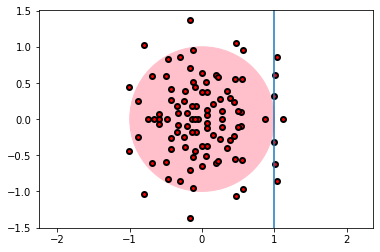

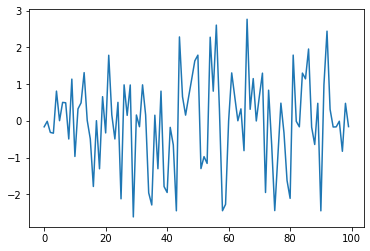

In [1226]:
gamma = 1
'''Network construction'''
W = W_orig.copy()
# Activate modes
n_modes = 4
print( r'{} availible modes\n'.format(len([x for x in plot_eigenvals(W,plot=False)[1]  if x>0])))

W, module = activate_n_modes(W,n=n_modes,plot=False); # Rescale W to activate modes

plot_eigenvals(W)
plt.axvline(x=1)

'''Choose if noise'''
simmulate_noise = True

'''Simulation parameters'''
sigma = 1/np.sqrt(N) 
dt=0.001
steps=int(2*1e4)
I_o=.1
if simmulate_noise: 
    N, steps, dt, sig, tau_ou = N,steps,dt, sigma, .1
    noise = my_OU(N,steps,dt, sig, tau_ou, seed=False) # Simulate noise
    

x_t = initial_state(N, 'Random')
y_t = x_t.copy()

X = np.zeros((steps+1,N))
Y = np.zeros((steps+1,N))
X[0] = x_t
Y[0] = y_t

'''Main loop'''
for i in tqdm(range(steps)):
    y_t = Euler2(y_t,W,gamma=gamma,sigma=0,dt=dt,I_o=I_o)
    Y[i+1,:] = y_t 
    if simmulate_noise:
        x_t = Euler2(x_t,W,gamma=gamma,sigma=sigma,dt=dt,I_o=I_o+noise[i,:])
        X[i+1,:] = x_t 


plt.figure()        
plt.plot(np.sum(W,0))    ;    

## Average activity

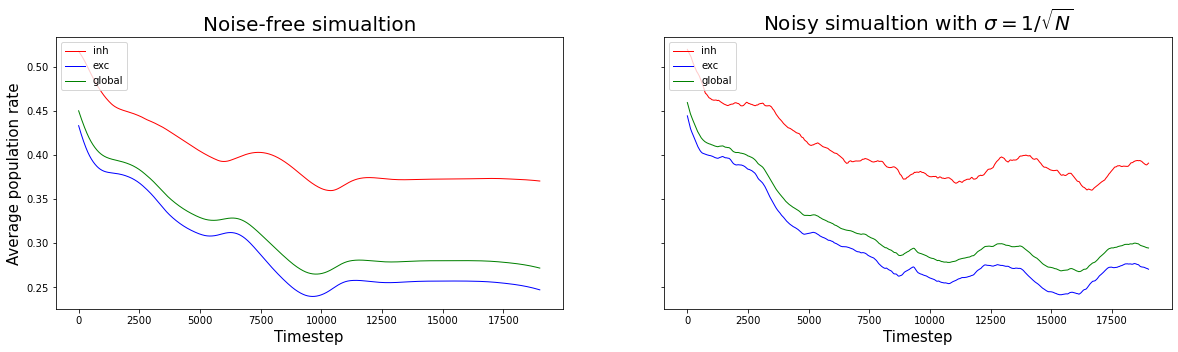

In [1227]:
fig = plt.figure(figsize=(20,5))
ax = fig.subplots(1,2, sharey=True, sharex=True)
burnin=1000

if simmulate_noise:
    S=np.sum(X[:,inh], axis=1)/len(inh)
    ax[1].plot(S[burnin:],lw=1,color='red', label='inh');
    S=np.sum(X[:,exc], axis=1)/len(exc)
    ax[1].plot(S[burnin:],lw=1,color='blue', label='exc');
    S=np.sum(X, axis=1)/N
    ax[1].plot(S[burnin:],lw=1,color='green', label='global');
    ax[1].legend(loc='upper left')
    ax[1].set_title('Noisy simualtion with $\sigma=1/\sqrt{N}$', size=20)
    ax[1].set_xlabel('Timestep',size=15)
    

S=np.sum(Y[:,inh], axis=1)/len(inh)
ax[0].plot(S[burnin:],lw=1,color='red', label='inh');
S=np.sum(Y[:,exc], axis=1)/len(exc)
ax[0].plot(S[burnin:],lw=1,color='blue', label='exc');
S=np.sum(Y, axis=1)/N
ax[0].plot(S[burnin:],lw=1,color='green', label='global');
ax[0].legend(loc='upper left')
ax[0].set_title('Noise-free simualtion', size=20)
ax[0].set_xlabel('Timestep',size=15)
ax[0].set_ylabel('Average population rate', size=15);#plt.ylim([.1,.2])

S=S-np.sum(Y[:,inh], axis=1)/len(inh)
#ax[0].plot(S[burnin:],lw=1,color='orange', label='diff')
#plt.tight_layout()
#plt.ylabel(r'$\langle x \rangle$', size=15);#plt.ylim([.1,.2])

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
#ax[0].text((steps-burnin)*1.1, np.mean(ax[1].get_ylim()), '$\gamma=${}'.format(gamma), fontsize=20,
#        verticalalignment='top', bbox=props);
#ax[0].set_xlim([0000,32000])
#ax[0].set_ylim([0,.002])
#b = [gamma*np.round(x,3) for x in mean_syn(W)]
#ax[0].plot(range(0,i),np.ones(i)*b[0])

## Time evolution with(out) noise

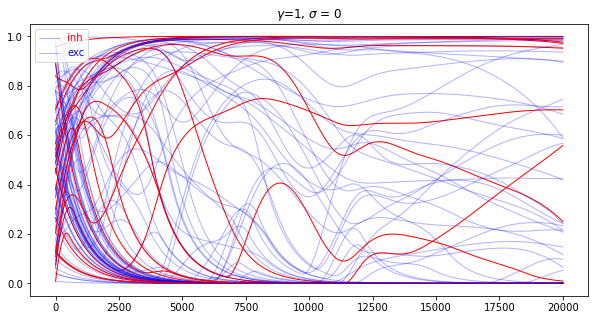

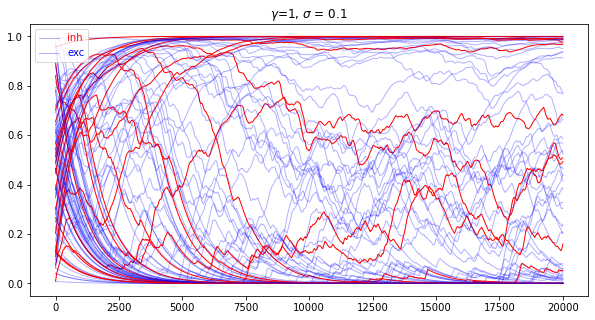

In [1229]:
plt.figure(figsize=(10,5))
for i in range(0,100):
    if i in inh:  plt.plot(Y.T[i], c= 'red', lw=1) 
    if i in exc:  plt.plot(Y.T[i], c='blue', lw=1, alpha=0.3 ) 
plt.title('$\gamma$={}, $\sigma$ = {}'.format(gamma,0));
plt.legend(['inh','exc'],labelcolor=['red','blue'], loc = 'upper left');
#plt.xlim([0,20000])
plt.figure(figsize=(10,5))
for i in range(0,100):
    if i in inh:  plt.plot(X.T[i], c= 'red', lw=1) 
    if i in exc:  plt.plot(X.T[i], c='blue', lw=1, alpha=0.3 ) 
plt.title('$\gamma$={}, $\sigma$ = {}'.format(gamma,sigma));
plt.legend(['inh','exc'],labelcolor=['red','blue'], loc = 'upper left');
#plt.xlim([0,20000])

## Tracking


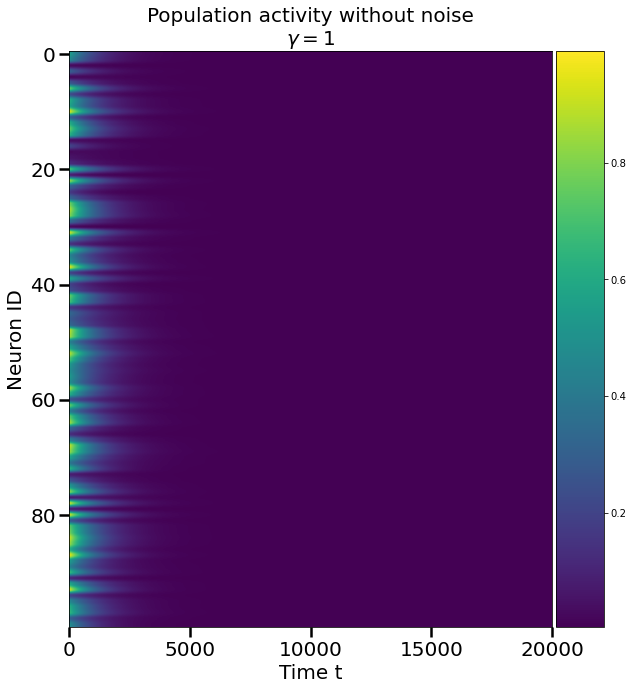

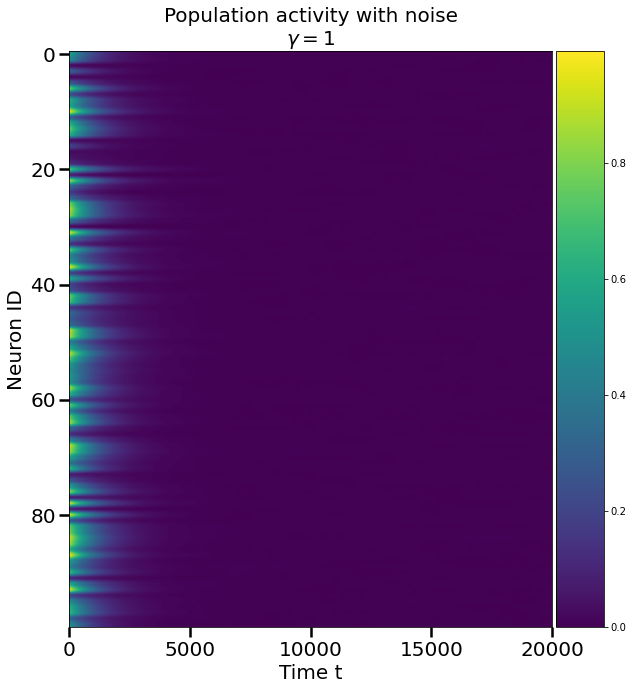

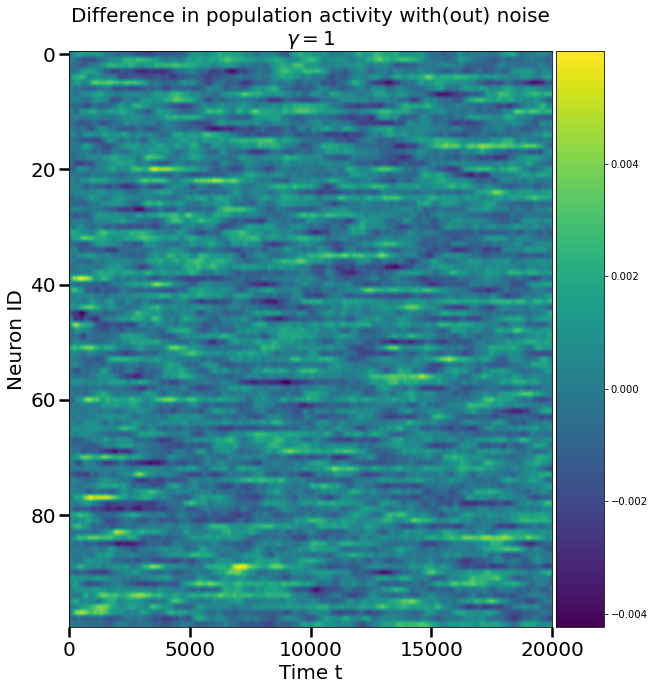

In [1171]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,figsize=(11,10))
im = axs.imshow(np.array(Y).T.tolist(), aspect='auto')
axs.set_title('Population activity without noise'+
              '\n$\gamma={}$'.format(gamma),fontsize=20)

axs.set_ylabel('Neuron ID',fontsize=20)
axs.set_xlabel('Time t',fontsize=20)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='10%', pad=0.05)

#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
fig.colorbar(im,cax=cax)
axs.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

fig, axs = plt.subplots(1,figsize=(11,10))
im = axs.imshow(np.array(X).T.tolist(), aspect='auto')
axs.set_title('Population activity with noise'+
              '\n$\gamma={}$'.format(gamma),fontsize=20)

axs.set_ylabel('Neuron ID',fontsize=20)
axs.set_xlabel('Time t',fontsize=20)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='10%', pad=0.05)

#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
fig.colorbar(im,cax=cax)
axs.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

fig, axs = plt.subplots(1,figsize=(11,10))
im = axs.imshow((np.array(X)-np.array(Y)).T.tolist(), aspect='auto')
axs.set_title('Difference in population activity with(out) noise'+
              '\n$\gamma={}$'.format(gamma),fontsize=20)

axs.set_ylabel('Neuron ID',fontsize=20)
axs.set_xlabel('Time t',fontsize=20)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='10%', pad=0.05)

#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
fig.colorbar(im,cax=cax)
axs.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)


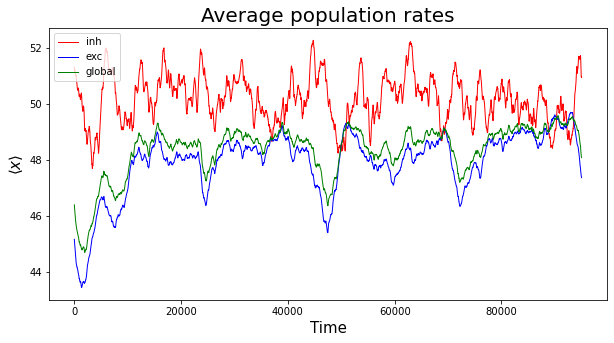

In [733]:
fig = plt.figure(figsize=(10,5))
S=np.sum(X[:,inh], axis=1)/len(inh)
plt.plot(S[5000:]*100,lw=1,color='red', label='inh');
S=np.sum(X[:,exc], axis=1)/len(exc)
plt.plot(S[5000:]*100,lw=1,color='blue', label='exc');
S=np.sum(X, axis=1)/N
plt.plot(S[5000:]*100,lw=1,color='green', label='global');
plt.legend(loc='upper left')
plt.title('Average population rates', size=20)
plt.xlabel('Time',size=15)
plt.ylabel(r'$\langle x \rangle$', size=15);#plt.ylim([.1,.2])



np.savetxt('burst_at_05_W',W)
np.savetxt('burst_at_05_inh',inh)

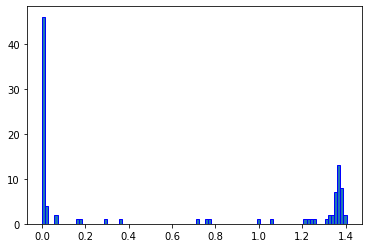

In [195]:
plt.hist(X[-1], np.linspace(min(X[-1]),max(X[-1]),100),edgecolor='b');

# Study of matrices

In [ ]:
## Outlier location for different 

[4.58327421 7.66168723 7.66168723]


[0.005127275064217949, 0.21831409795063644, 0.04776463964150164]

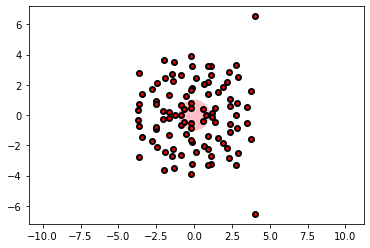

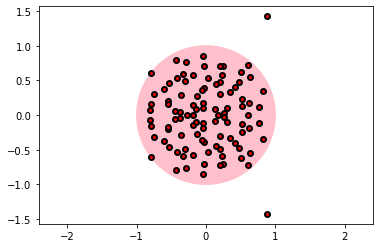

In [761]:
''' Create synaptic matrix'''
# 0.8*muE = 4*muE*x

#muE = 1/np.sqrt(N)
muE=1
W, inh = full(N, muE= muE, muI=4*muE, nI=0.2)

#W, inh = full(N, muE=.2, muI=.8, nI=.2)
W = sparse2(W,k=20)
W = modulate_II(W)

moduli = plot_eigenvals(W) 
print(moduli)
# Normalize
if abs(moduli[2]-moduli[1])<.0001: W = W/moduli[0]
else: W = W/moduli[1]

plt.figure()
plot_eigenvals(W)
mean_syn(W)

## Superposition of eigenvals for M simulated matrices

Text(0.5, 1.0, 'Average synaptic strenghts')

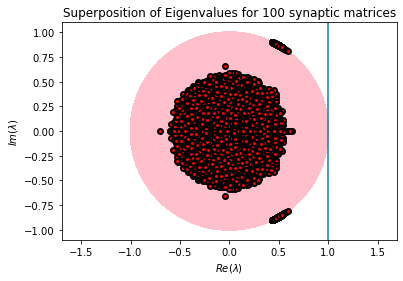

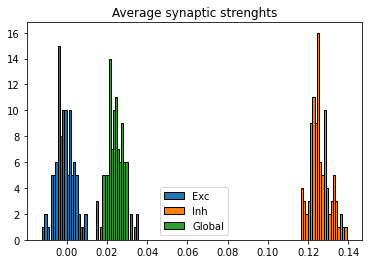

In [660]:
syn = []


plt.ioff()
NN=100
for i in range(NN):
    W, inh = full(N, muE= muE, muI=4*muE, nI=.2)
    W = sparse2(W,k=20)
    W = modulate_II(W)

    moduli = plot_eigenvals(W,plot=False); 
    
    # Normalize
    #if abs(moduli[2]-moduli[1])<.0001: W = W/moduli[0]
    #else: W = W/moduli[1]
    W = W/moduli[-1]
        
    syn.append(mean_syn(W))
    moduli = plot_eigenvals(W)
    plt.title('Superposition of Eigenvalues for {} synaptic matrices'.format(NN))
    plt.xlabel(r'$Re(\lambda)$')
    plt.ylabel(r'$Im(\lambda)$')

plt.axvline(x=1)

syn = np.array(syn)
plt.figure()
plt.hist(syn[:,0],20, edgecolor='black', label='Exc')
plt.hist(syn[:,1],20, edgecolor='black', label='Inh')
plt.hist(syn[:,2],20, edgecolor='black', label='Global');
plt.legend()
plt.title('Average synaptic strenghts')

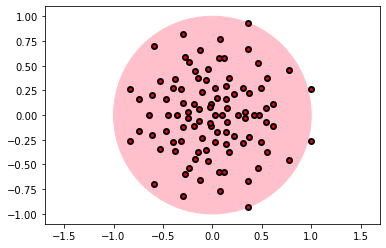

In [678]:
W, inh = full(N, muE= muE, muI=4*muE, nI=.2)
W = sparse2(W,k=20)
moduli = plot_eigenvals(W,plot=False); 
    
    # Normalize
if abs(moduli[2]-moduli[1])<.0001: W = W/moduli[0]
else: W = W/moduli[1]
#W = W/moduli[-1]

plot_eigenvals(W,plot=True); 

## Average connectivities histogram

Text(0, 0.5, 'Counts')

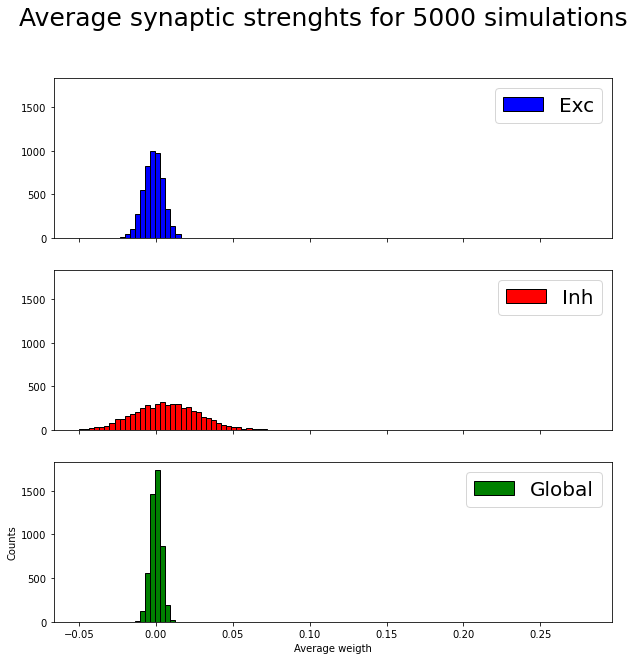

In [648]:
fig = plt.figure(figsize=(10,10))
ax = fig.subplots(3,1, sharey=True, sharex=True)

bins, Range = 100, (-.05,0.28)
a,b= np.histogram(syn[:,0],bins=bins, range=Range)
xs = [(b[i]+b[i+1])/2 for i in range(len(a))]
width= b[1]-b[0]
reshape = width/NN*bins*N

ax[0].bar(xs,a,width=width,color='blue',edgecolor='black', label='Exc')
a,b= np.histogram(syn[:,1],bins=bins, range=Range)
ax[0].legend(fontsize=20)

ax[1].bar(xs,a,width=width, color='red',edgecolor='black', label='Inh')
a,b= np.histogram(syn[:,2],bins=bins, range=Range)
ax[1].legend(fontsize=20, loc='upper right')

ax[2].bar(xs,a,width=width,color='green',edgecolor='black', label='Global')
ax[2].legend(fontsize=20)
plt.suptitle('Average synaptic strenghts for {} simulations'.format(NN),size=25)
plt.xlabel('Average weigth')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

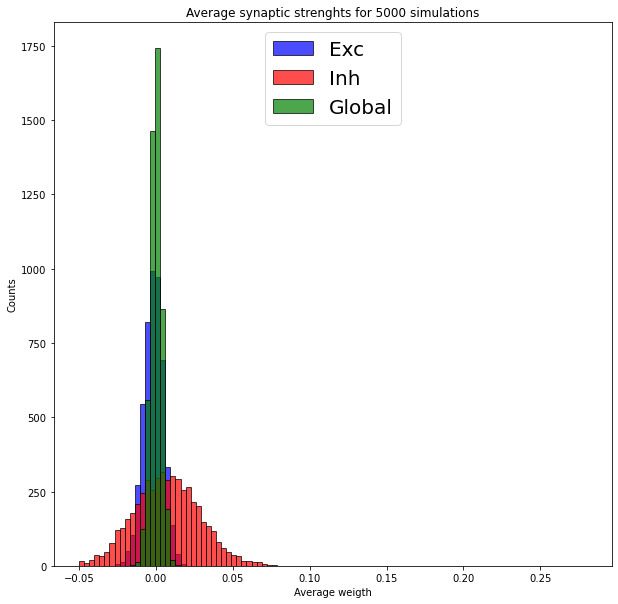

In [649]:
plt.figure(figsize=(10,10))
bins, Range = 100, (-.05,0.28)
a,b= np.histogram(syn[:,0],bins=bins, range=Range)
xs = [(b[i]+b[i+1])/2 for i in range(len(a))]
width= b[1]-b[0]
reshape = width/NN*bins*N

plt.bar(xs,a,width=width,color='blue',edgecolor='black', label='Exc',alpha=0.7)
a,b= np.histogram(syn[:,1],bins=bins, range=Range)

plt.bar(xs,a,width=width,color='red',edgecolor='black', label='Inh',alpha=0.7)
a,b= np.histogram(syn[:,2],bins=bins, range=Range)

plt.bar(xs,a,width=width,color='green',edgecolor='black', label='Global',alpha=0.7)
plt.legend(fontsize=20,loc='upper center')
plt.title('Average synaptic strenghts for {} simulations'.format(NN))
plt.xlabel('Average weigth')
plt.ylabel('Counts')

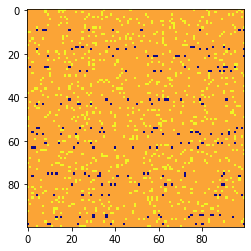

<Figure size 432x288 with 0 Axes>

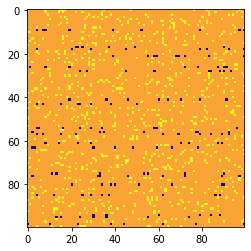

In [773]:
# Full graph
W, inh = full(100, muE=1, muI=4*muE, nI=.2)

# Add sparsity (20 non-zero connections)
W = sparse2(W,k=20)
plot_eigenvals(W,False)
plt.figure()
plt.imshow(W, cmap='plasma', interpolation='nearest')

# Eliminate Inh-Inh connections
W = modulate_II(W)
plt.figure()
plot_eigenvals(W,False)
plt.figure()
plt.imshow(W, cmap='plasma', interpolation='nearest')

W, inh = full(N, muE=.1, muI=.4, nI=.2) 

W = sparse2(W,k=5)

gamma = 2.7

sigma = 1/np.sqrt(N)

Critical at about gamma 2.7!

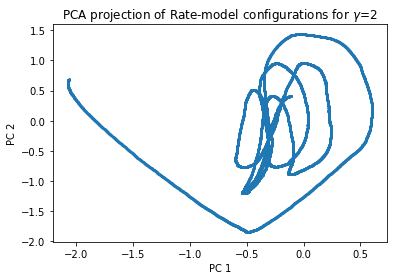

In [785]:
from sklearn.decomposition import PCA
import numpy as np
S= np.array(X)
S.T.shape

pca = PCA(n_components=2)
#B = pca.fit(S[1000:])
B = pca.fit_transform(S[10000:])

plt.title('PCA projection of Rate-model configurations for $\gamma$={}'.format(gamma))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
#plt.scatter(B[:,0],B[:,1], s=1);
#plt.scatter(*pca.fit_transform(S).T,s=1)
plt.scatter(B[12000:,0],B[12000:,1], s=1)


In [ ]:
pca.fit(S[5000:])
pca.explained_variance_ratio_

In [ ]:
from scipy.stats import gaussian_kde

xy = np.vstack([B[:,0],B[:,1]])
z = gaussian_kde(xy)(xy)

plt.scatter(B[:,0],B[:,1], c=z, s=1)
plt.title('Point density of projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

**Interesting dynamics:** 

W, inh = full(N, muE=1, muI=4, nI=.2)

W = sparse2(W,k=5)

x_t = initial_state(N, 'Uniform')

gamma = .8

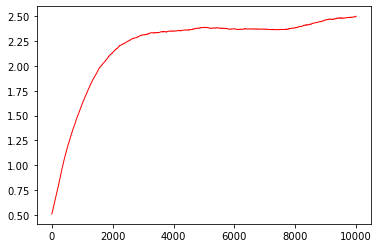

In [162]:
S=np.sum(X, axis=1)/N
plt.plot(S,lw=1,color='red');


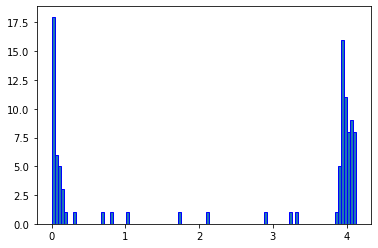

In [163]:
#plt.hist(X[0], np.linspace(min(X[-1]),max(X[-1]),100),edgecolor='b',density=True,stacked=True);
plt.hist(X[-1], np.linspace(min(X[-1]),max(X[-1]),100),edgecolor='b');

In [25]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)
B= pca.fit_transform(S[:N,10000:].T)

plt.title('PCA projection of SK configurations for T={}'.format(T))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.scatter(B[:,0],B[:,1], s=1);


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

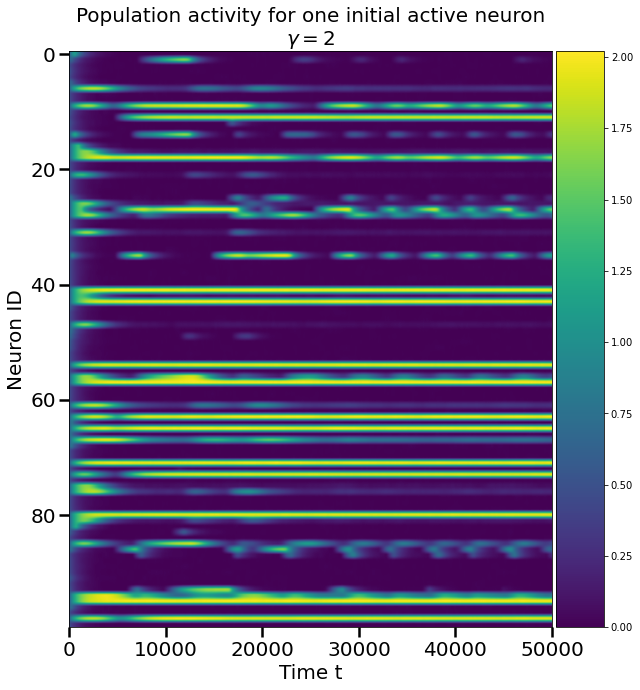

In [786]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,figsize=(11,10))
im = axs.imshow(np.array(X).T.tolist(), aspect='auto')
axs.set_title('Population activity for one initial active neuron'+
              '\n$\gamma={}$'.format(gamma),fontsize=20)

axs.set_ylabel('Neuron ID',fontsize=20)
axs.set_xlabel('Time t',fontsize=20)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='10%', pad=0.05)

#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
fig.colorbar(im,cax=cax)
axs.tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
